In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import matplotlib.pyplot as plt

In [ ]:
POPULATION_SIZE = 10            
MUTATION_RATE = 0.2           
GENERATIONS = 100               
SCORE_TO_ACHIEVE = 50           
FITNESS_THRESHOLD = 14         
ELITE_COUNT = 2                 
SCORE_TO_ACHIEVE

ROWS = 19                     
COLS = 30                      
HEX_RADIUS = 1                 

MAP_NAME = "GeneticBestMap"
NUMBER_OF_PLAYERS = 1


In [3]:

tundra_colours = {"Mountain": "#7FB8A4", "Hill": "#A3C4A7", "Flat": "#B7D1A3"}
grassland_colours = {"Mountain": "#6E9E3E", "Hill": "#8FBF4A", "Flat": "#A3D14A"}
plains_colours = {"Mountain": "#C4B37F", "Hill": "#D1C48A", "Flat": "#E0D1A3"}
tropical_colours = {"Mountain": "#6E9E8F", "Hill": "#8FBF9E", "Flat": "#A3D1B7"}
desert_colours = {"Mountain": "#C4B37F", "Hill": "#D1C48A", "Flat": "#E0D1A3"}
marine_colours = {"Coast": "#3E6E9E", "Ocean": "#4A8FBF"}

biome_colours = {
    "Tundra": tundra_colours,
    "Grassland": grassland_colours,
    "Plains": plains_colours,
    "Tropical": tropical_colours,
    "Desert": desert_colours,
    "Marine": marine_colours
}


In [4]:

def generate_hex_grid(rows, cols, biomes, num_players):
    
    # Generate all tiles (row, col)
    all_positions = [(r, c) for r in range(rows) for c in range(cols)]
    
    # Randomly place tiles for players
    start_positions = random.sample(all_positions, num_players)

    # Tile data dictionary to store color, biome, terrain
    tile_data = {}

    # For every tile, give set a property
    for row in range(rows):
        for col in range(cols):

            # If the position coordinates are a start position, make it black
            if (row, col) in start_positions:
                hex_color = 'black'
                biome = 'Spawn'
                terrain_type = 'Spawn'
            else:
                # Pick a random biome and terrain
                biome = random.choice(list(biomes.keys()))
                terrain_type = random.choice(list(biomes[biome].keys()))
                hex_color = biomes[biome][terrain_type]  # Get color

            # Store the tile data (row, col)
            tile_data[(row, col)] = {
                'color': hex_color,
                'biome': biome,
                'terrain': terrain_type
            }

    return start_positions, tile_data


In [5]:

def plot_map(ax, tile_map, spawns):
    hex_height = math.sqrt(3) * HEX_RADIUS

    for (row, col), tile_info in tile_map.items():
        x_offset = col * 1.5 * HEX_RADIUS
        y_offset = row * hex_height + (hex_height / 2 if col % 2 == 1 else 0)
        hex_color = tile_info['color']

        # Spawn positions are black
        if (row, col) in spawns:
            hex_color = 'black'

        hex_tile = patches.RegularPolygon(
            (x_offset, y_offset),
            numVertices=6,
            radius=HEX_RADIUS,
            orientation=math.radians(30),
            facecolor=hex_color,
            edgecolor='black'
        )
        ax.add_patch(hex_tile)

    ax.set_aspect('equal')
    ax.autoscale_view()
    ax.axis('off')


def plot_top_maps(top_maps):

    # Sort maps in descending order
    top_maps = sorted(top_maps, key=lambda x: x['score'], reverse=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(ROWS, COLS))

    # Plot top 2 maps
    spawns1, tile_map1 = top_maps[0]['spawns'], top_maps[0]['map']
    ax1.set_title(f"Map 1: Score {top_maps[0]['score']}")
    plot_map(ax1, tile_map1, spawns1)

    spawns2, tile_map2 = top_maps[1]['spawns'], top_maps[1]['map']
    ax2.set_title(f"Map 2: Score {top_maps[1]['score']}")
    plot_map(ax2, tile_map2, spawns2)

    plt.show()


def display_best_map(tile_map, spawns, score=None):
    fig, ax = plt.subplots(figsize=(ROWS, COLS))
    title = f"Best Map"
    if score:
        title += f" - Score {score}"
    ax.set_title(title)
    plot_map(ax, tile_map, spawns)
    plt.show()


In [6]:
def rate_map(tile_data, start_positions, rows, cols):
    
    #Coordinates of neighbours from 'this' position
    def neighbors(pos):
        row, col = pos
        even_col = col % 2 == 0
        directions = [(-1, 0), (-1, +1), (0, -1), (0, +1), (+1, 0), (+1, +1)] if even_col else \
                     [(-1, -1), (-1, 0), (0, -1), (0, +1), (+1, -1), (+1, 0)]
        return [(row + dr, col + dc) for dr, dc in directions if 0 <= row + dr < rows and 0 <= col + dc < cols]

    biome_score = 0
    terrain_score = 0
    spawn_score = 0

    # Biome and terrain clustering
    for (row, col), tile in tile_data.items():
        if tile['biome'] == "Spawn":
            continue

        neighbors_list = [
            n for n in (tile_data.get(pos) for pos in neighbors((row, col))) if n
        ]
        
        # Biome clustering score
        biome_score += sum(n['biome'] == tile['biome'] for n in neighbors_list)

        if tile['biome'] != 'Marine':
            continue

        terrain = tile['terrain']
        water_neighbors = [n for n in neighbors_list if n['terrain'] in ['Ocean', 'Coast']]
        land_adjacent = any(n['biome'] != 'Marine' for n in neighbors_list)

        if terrain == 'Ocean':
            if land_adjacent:
                terrain_score -= 5
            terrain_score += len(water_neighbors)

        elif terrain == 'Coast':
            water_adjacent = any(n['terrain'] in ['Ocean', 'Coast'] for n in neighbors_list)
            terrain_score += 3 if water_adjacent and land_adjacent else -2


    # Spawn fairness: only if more than one player
    if (len(start_positions) > 1):
        dists = [
            math.sqrt((r2 - r1) ** 2 + (c2 - c1) ** 2)
            for i, (r1, c1) in enumerate(start_positions)
            for r2, c2 in start_positions[i + 1:]
        ]
        avg_dist = sum(dists) / len(dists)
        std_dev = np.std(dists)
        spawn_score += avg_dist * 5
        spawn_score -= std_dev * 2

    # Marine spawn penalty
    for pos in start_positions:
        tile = tile_data.get(pos)
        if tile and tile['biome'] == 'Marine':
            spawn_score -= 100

    # Normalize score
    total_raw_score = biome_score + terrain_score + spawn_score
    max_possible = rows * cols * 6
    rating = int(np.clip((total_raw_score / max_possible) * 100, 0, 100))
    return rating


In [7]:

# Initial population
def generate_initial_population(min_valid_maps=2, fitness_threshold=FITNESS_THRESHOLD, score_to_achieve=SCORE_TO_ACHIEVE):
    best_maps = []
    scores = []
    attempts = []

    attempt = 1
    while len(best_maps) < min_valid_maps:
        
        # Generate a new map and rate it
        spawns, tile_map = generate_hex_grid(rows=ROWS, cols=COLS, biomes=biome_colours, num_players=NUMBER_OF_PLAYERS)
        score = rate_map(tile_map, spawns, ROWS, COLS)

        scores.append(score)
        attempts.append(attempt)

        # Save maps that are good
        if score >= fitness_threshold:
            best_maps.append({
                'score': score,
                'spawns': spawns,
                'map': tile_map
            })
            print(f"🟢 Saved map {len(best_maps)} with score {score}")
        else:
            print(f"🔴 Discarded map with score {score}")

        # If score exceeds the goal, stop searching
        if score >= score_to_achieve:
            print(f"\n🟢 Found map with score {score}/100 on attempt {attempt}")
            print("Player start positions:", spawns)
            break

        attempt += 1

    print(f"\nDone : {len(best_maps)} maps above {fitness_threshold} fitness")
    return best_maps


🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 13
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 11
🟢 Saved map 1 with score 14
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 13
🔴 Discarded map with score 12
🟢 Saved map 2 with score 14

Done : 2 maps above 14 fitness


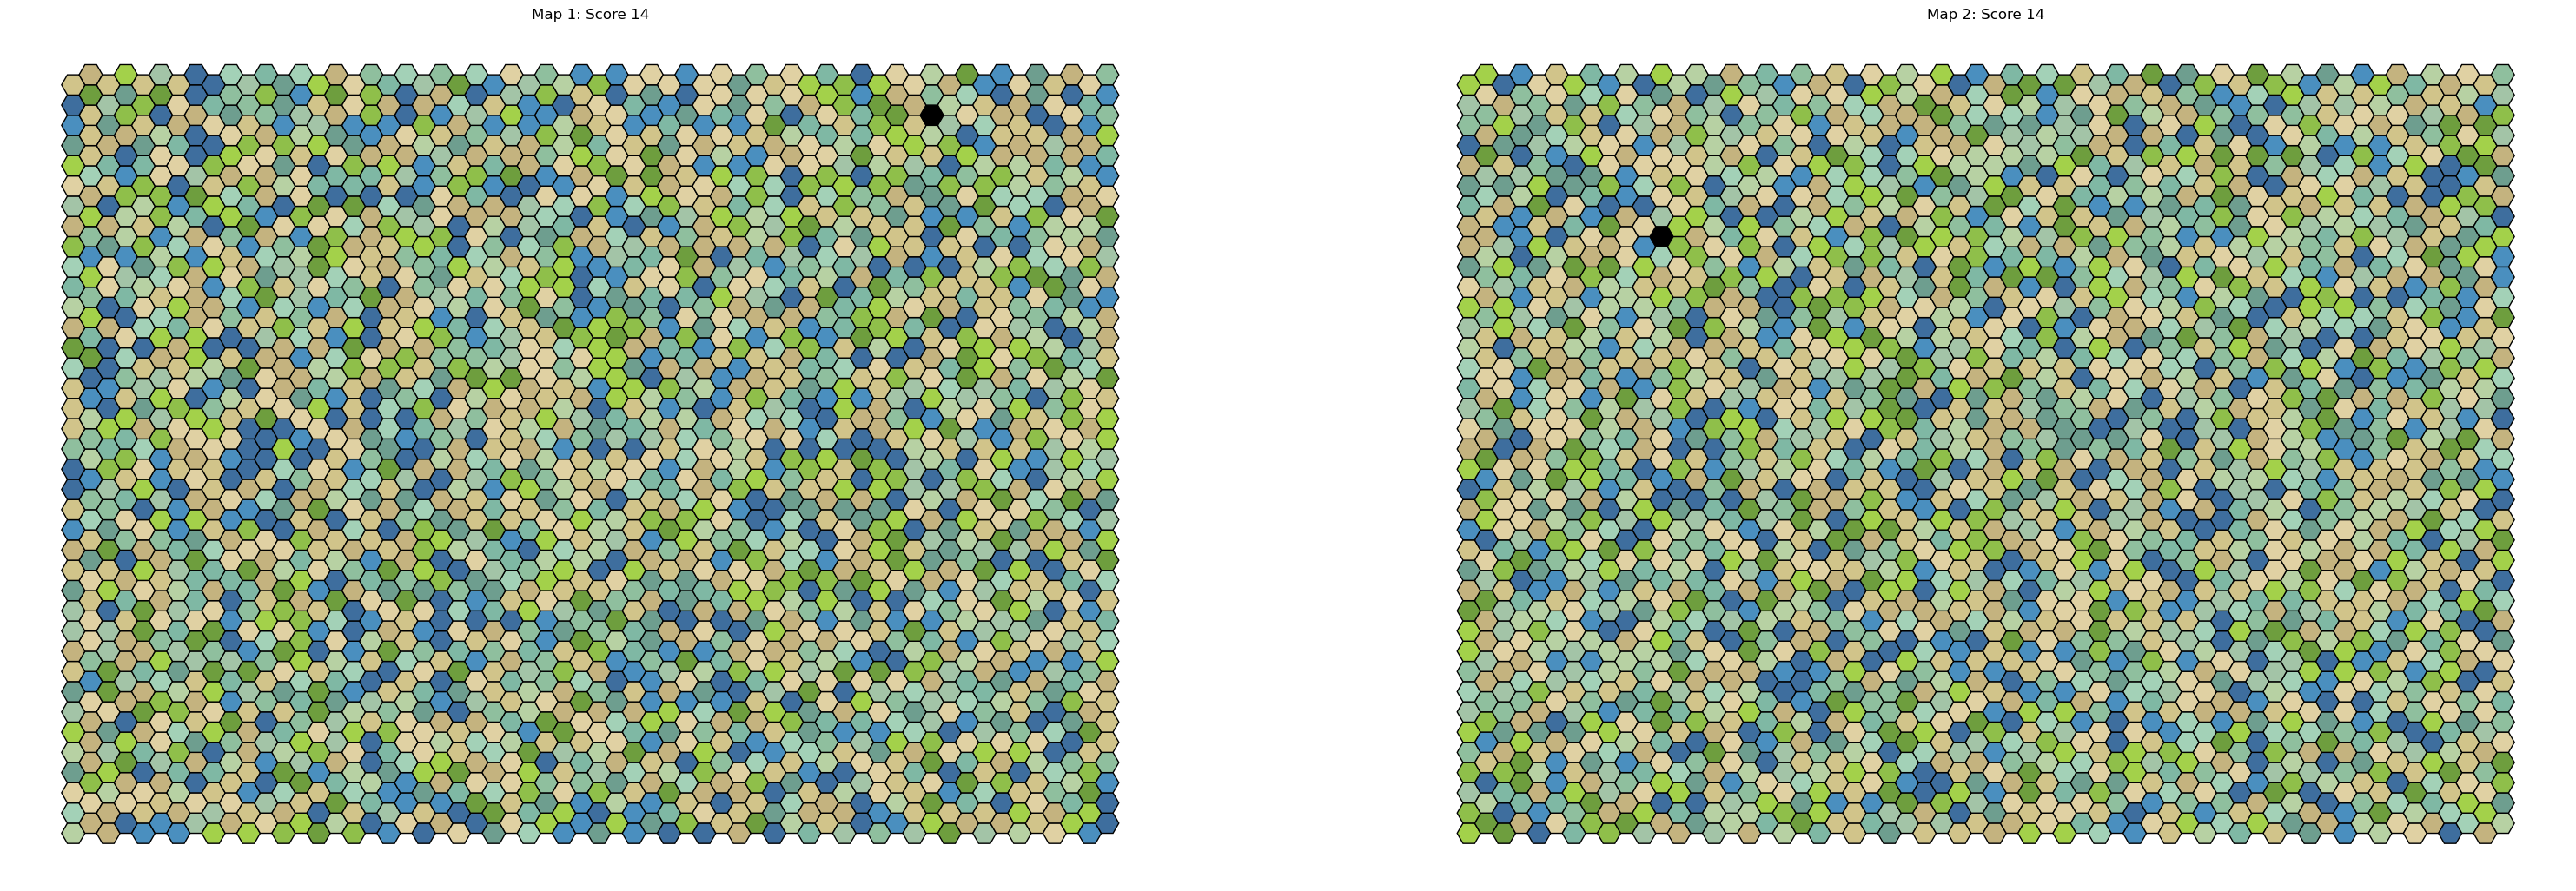

In [17]:
# ===== DEBUG =====

top_maps = generate_initial_population(min_valid_maps=2, fitness_threshold=FITNESS_THRESHOLD)

if len(top_maps) >= 2:
    plot_top_maps(top_maps)

In [9]:

# === Elitism Selection ===
def elitism_selection(population, elite_count=ELITE_COUNT):

    return sorted(population, key=lambda m: m['score'], reverse=True)[:elite_count]

# === Mutation ===
def mutate_map(individual, mutation_rate=MUTATION_RATE):
    tile_map = individual['map']
    if random.random() < mutation_rate:
        target_tile = random.choice(list(tile_map.keys()))
        biome = random.choice(list(biome_colours.keys()))
        terrain = random.choice(list(biome_colours[biome].keys()))
        tile_map[target_tile]['biome'] = biome
        tile_map[target_tile]['terrain'] = terrain
        tile_map[target_tile]['color'] = biome_colours[biome][terrain]
    return individual

# === Reproduce ===
def reproduce_population(parents, total_size=POPULATION_SIZE):
    children = []
    while len(children) < total_size:
        # Select a random parent and clone their map
        clone = random.choice(parents).copy()
        clone['map'] = {k: v.copy() for k, v in clone['map'].items()}  # Deep copy map
        children.append(clone)
    return children

# === Plotting Function ===
def plot_fitness_over_time(generations, scores, score_to_achieve=SCORE_TO_ACHIEVE):
    plt.plot(generations, scores, color='blue')
    plt.axhline(y=score_to_achieve, color='red', linestyle='--', label='Target Score')
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Fitness Over Generations")
    plt.legend()
    plt.show()


In [10]:
def run_genetic_ai_until_goal(population_size=POPULATION_SIZE, fitness_threshold=FITNESS_THRESHOLD, mutation_rate=MUTATION_RATE, score_to_achieve=SCORE_TO_ACHIEVE):
    
    # Generate initial population
    population = generate_initial_population(population_size, fitness_threshold)

    history = []
    generation = 0

    while True:
        # Elitism: select top performers
        elite = elitism_selection(population)

        # Reproduce: clone elites to refill population
        population = reproduce_population(elite, population_size)

        # Mutate each individual slightly
        population = [mutate_map(ind, mutation_rate) for ind in population]

        # Re-rate population
        for individual in population:
            individual['score'] = rate_map(individual['map'], individual['spawns'], ROWS, COLS)

        # Track best score
        best = max(population, key=lambda x: x['score'])
        history.append(best['score'])
        generation += 1

        print(f"Gen {generation}: Best Score = {best['score']}")

        # Check if the target score has been achieved
        if best['score'] >= score_to_achieve:
            print(f"\n🏆 Success! Map hit score {best['score']} in generation {generation}")
            break

    # Plot final fitness progress
    plot_fitness_over_time(list(range(1, len(history) + 1)), history, score_to_achieve)

    return best  # Optionally return best individual


In [25]:
best_map = run_genetic_ai_until_goal(POPULATION_SIZE, FITNESS_THRESHOLD, MUTATION_RATE, SCORE_TO_ACHIEVE)

tile_data = best_map['map']
start_positions = best_map['spawns']

# Display the generated map visually
display_best_map(tile_data, start_positions)

# Compute map dimensions from tile_data
width = max(c for (_, c) in tile_data.keys()) + 1
height = max(r for (r, _) in tile_data.keys()) + 1



🔴 Discarded map with score 11
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 10
🔴 Discarded map with score 10
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 11
🔴 Discarded map with score 13
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🟢 Saved map 1 with score 14
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 11
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🟢 Saved map 2 with score 14
🔴 Discarded map with score 11
🔴 Discarded map with score 12
🔴 Discarded map with score 10
🔴 Discarded map with score 12
🔴 Discarded map with score 11
🟢 Saved map 3 with score 14
🔴 Discarded map 

KeyboardInterrupt: 

In [ ]:

plot = display_best_map(tile_data, start_positions)
plot.savefig('bestmap.png')

In [ ]:
maps = [
    run_genetic_ai_until_goal(POPULATION_SIZE, FITNESS_THRESHOLD, MUTATION_RATE, SCORE_TO_ACHIEVE / 2),
    run_genetic_ai_until_goal(POPULATION_SIZE, FITNESS_THRESHOLD, MUTATION_RATE, SCORE_TO_ACHIEVE / 2)
]

for map in maps:

    tile_data = best_map['map']
    start_positions = best_map['spawns']

    # Display the generated map visually
    display_best_map(tile_data, start_positions)

    # Compute map dimensions from tile_data
    width = max(c for (_, c) in tile_data.keys()) + 1
    height = max(r for (r, _) in tile_data.keys()) + 1

